# Small Nexus: 2015 Drought
a. stein 11.1.2022

So drawing the entire nexus is too big, even for `pyvis`. Also, doing any computations on a graph that has multiple drought threads (meaning a discontinuous graph) greatly interferes with efforts to measure connectivity. So here I want to try isolating a drought thread to do a smaller scale analysis. For this I'll use the 2015 drought.

In [69]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot
import ndrought.drought_network as dnet

from pyvis.network import Network

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in data

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

In [3]:
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')

In [4]:
usdm_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/usdm/usdm_WA_net.pickle')

In [5]:
pdsi = xr.open_dataset(f'{dm_path}/pdsi/WA/pdsi_usdmcat_WA.nc')

In [6]:
pdsi_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/pdsi/WA/pdsi_WA_net.pickle')

## Match & Overlap data

In [7]:
matched_dates = compare.pair_to_usdm_date(pd.to_datetime(usdm.date.values), pd.to_datetime(pdsi.day.values), 'PDSI', realign=True)

In [8]:
pdsi_date_idx = []

for date in matched_dates['PDSI'].values:
    pdsi_date_idx.append(np.where(pdsi.day.values == date)[0][0])
usdm_date_idx = []

for date in matched_dates['USDM Date'].values:
    usdm_date_idx.append(np.where(usdm.date.values == date)[0][0])
    
matched_dates_dict = dict()
for usdm_date, pdsi_date in zip(usdm_date_idx, pdsi_date_idx):
    matched_dates_dict[usdm_date] = pdsi_date

In [9]:
overlap_events = usdm_net.find_overlapping_nodes_events(pdsi_net, matched_dates_dict)

  0%|          | 0/86991324 [00:00<?, ?it/s]

## Select out 2015 Drought

Okay, so I have already identified for the USDM that the drought event that best captures the 2015 drought starts at id 893.

In [10]:
usdm_thread_893 = usdm_net.get_chronological_future_thread(id=893)
usdm_ids_893 = [node.id for node in usdm_thread_893]
usdm_adj_dict_893 = usdm_net.filter_adj_dict_by_id(usdm_ids_893)

In [11]:
usdm_thread_893[0].time

731

In [12]:
usdm_thread_893[-1].time

846

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

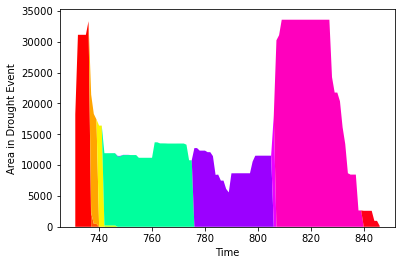

In [13]:
usdm_net.stacked_events_plot(id=893)

Let's make the staked plots for pdsi to find where it's got the 2015 drought

In [14]:
np.where(pdsi['day'].values == pdsi['day'].sel(day='2014').values[0])

(array([731]),)

In [15]:
np.where(pdsi['day'].values == pdsi['day'].sel(day='2015').values[0])

(array([783]),)

In [16]:
np.where(pdsi['day'].values == pdsi['day'].sel(day='2016').values[0])

(array([835]),)

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

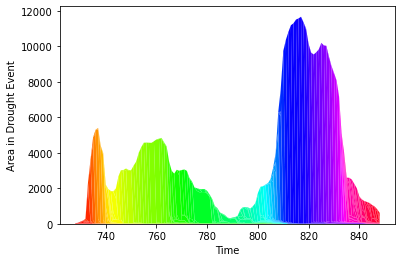

In [17]:
pdsi_net.stacked_events_plot(start_time=728, end_time=848)

That looks like it covers the same thing ... now to trace it

In [18]:
potential_pdsi_threads = pdsi_net.time_slice(728, 848)

In [33]:
np.array([node.time for node in potential_pdsi_threads])

array([728, 728, 728, ..., 848, 848, 848])

In [20]:
len(potential_pdsi_threads)

3667

In [46]:
times = pd.to_datetime(pdsi.day.values[728:849])
times

DatetimeIndex(['2013-12-16', '2013-12-21', '2013-12-31', '2014-01-05',
               '2014-01-10', '2014-01-20', '2014-01-25', '2014-02-04',
               '2014-02-09', '2014-02-14',
               ...
               '2016-01-30', '2016-02-09', '2016-02-14', '2016-02-19',
               '2016-02-29', '2016-03-05', '2016-03-15', '2016-03-20',
               '2016-03-25', '2016-04-04'],
              dtype='datetime64[ns]', length=121, freq=None)

In [48]:
test_pdsi_adj_dict = pdsi_net.filter_adj_dict_by_id([node.id for node in potential_pdsi_threads])

In [50]:
pdsi_net.create_animated_gif('test/pdsi_2015_drought_test.gif', 
                             adj_dict=test_pdsi_adj_dict, 
                             times=times, 
                             fps=4, overwrite=True)

Okay, those look right. Hard to say if more should be trimmed, but I think that they shouldn't because PDSI is much more spatially segmented than USDM where I did filter to a thread.

In [56]:
usdm_2015_ids = usdm_thread_893
pdsi_2015_ids = potential_pdsi_threads

In [57]:
usdm_2015_adj_dict = usdm_adj_dict_893
pdsi_2015_adj_dict = test_pdsi_adj_dict

In [62]:
G_usdm = nx.Graph(usdm_2015_adj_dict)
G_pdsi = nx.Graph(pdsi_2015_adj_dict)

In [63]:
G_usdm_relab = ndplot.attach_dm_node_label(G_usdm, 'usdm')
G_pdsi_relab = ndplot.attach_dm_node_label(G_pdsi, 'pdsi')

In [66]:
G_usdm_pdsi = nx.union(G_usdm_relab, G_pdsi_relab)

In [68]:
G_usdm_pdsi_connected = ndplot.connect_overlap_nodes(G_usdm_pdsi, overlap_events, 'usdm', 'pdsi')

In [70]:
g = Network(notebook=True)
g.toggle_physics('True')
g.from_nx(G_usdm_pdsi_connected.copy())

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


g.show('example.html')